# Imports

In [10]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [11]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download TKL data from YF

In [12]:
tickers_yf = {
    "y"     : f"{project_config['TKL']}",
    "NASDAQ"       : "^IXIC",
    "SP500"        : "^GSPC",
    "Gold"         : "GC=F",
    "Oil"          : "CL=F",
    "RealEstate"   : "VNQ",
    "Inflation_Exp": "^TNX"
}

desired_order = [
    "Date",
    "y",
    "NASDAQ",
    "SP500",
    "Oil",
    "Gold",
    "RealEstate",
    "Inflation_Exp",
]

In [13]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

# from datetime import date, timedelta
# end_date = date.today() - timedelta(days=1)
# start_date = end_date - timedelta(days=int(project_config["HISTORY_DEPTH"]))

# ---- DOWNLOAD FROM YAHOO FINANCE ----
# ts_yf = yf.download(
#     tickers=list(tickers_yf.values()),
#     start=start_date,
#     end=end_date,
#     auto_adjust=True
# )["Close"]

ts_yf = yf.download(
    tickers=list(tickers_yf.values()),
    period="max",
    auto_adjust=True
)["Close"]
ts_yf = ts_yf.tail(int(project_config["HISTORY_DEPTH"]))

# rename columns to readable names
rename_map = {v: k for k, v in tickers_yf.items()}
ts_yf = ts_yf.rename(columns=rename_map)

# Fill missing daily values for macro data (monthly)
ts_yf = ts_yf.fillna(method='ffill').fillna(method='bfill')
ts_yf = ts_yf.reset_index().rename(columns={"Date": "Date",})

print(f"\n\nDataset for y={project_config['TKL']}")
display(ts_yf.head(1))
display(ts_yf.tail(1))
ts_yf.info()

[*********************100%***********************]  7 of 7 completed



Dataset for y=ATCMF


Ticker,Date,y,Oil,Gold,RealEstate,SP500,NASDAQ,Inflation_Exp
0,1998-03-02,0.945,32.049999,273.899994,20.059341,1047.699951,1758.540039,5.703


Ticker,Date,y,Oil,Gold,RealEstate,SP500,NASDAQ,Inflation_Exp
6999,2025-12-17,0.159,56.110001,4360.200195,89.07,6800.259766,23111.460938,4.149


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           7000 non-null   datetime64[ns]
 1   y              7000 non-null   float64       
 2   Oil            7000 non-null   float64       
 3   Gold           7000 non-null   float64       
 4   RealEstate     7000 non-null   float64       
 5   SP500          7000 non-null   float64       
 6   NASDAQ         7000 non-null   float64       
 7   Inflation_Exp  7000 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 437.6 KB


# Turn time-series into scaled supprvied ML table

In [14]:
df = ts_yf.copy()
df_orig = ts_yf.copy()

# Keep Date
date_col = df["Date"]

# Targets
y_col = ['y']

# Features
X_cols = df.drop(columns=y_col+['Date']).columns

# Initialize scalers
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Scale
df_X_scaled = pd.DataFrame(X_scaler.fit_transform(df[X_cols]),
                           columns=X_cols, index=df.index)

df_y_scaled = pd.DataFrame(y_scaler.fit_transform(df[y_col]),
                           columns=y_col, index=df.index)

# Rebuild dataframe
df = pd.concat([date_col, df_X_scaled, df_y_scaled], axis=1)

df = df[desired_order]
df_orig = df_orig[desired_order]

del df_X_scaled, df_y_scaled

display(df.tail(1))
display(df_orig.tail(1))

,Date,y,NASDAQ,SP500,Oil,Gold,RealEstate,Inflation_Exp
6999,2025-12-17,0.141649,0.962923,0.983815,0.512464,1.0,0.877166,0.581025


Ticker,Date,y,NASDAQ,SP500,Oil,Gold,RealEstate,Inflation_Exp
6999,2025-12-17,0.159,23111.460938,6800.259766,56.110001,4360.200195,89.07,4.149


In [15]:
def generate_ts_features(df, lags=[1,2,3,4,5,6,10,22,66], windows=[1,2,3,4,5,6,10,22,66]):

  # Identify columns to generate features for (excluding 'index' column which is the date)
  base_cols = [c for c in df.columns if c not in ['Date','index']]

  for base_col in base_cols:

    for lag in lags:
      df[f"{base_col}_lag_{lag}"] = df[base_col].shift(lag)

  # Generate rolling window statistics for the current base_col
    for window in windows:
      df[f"{base_col}_min_{window}"] = df[base_col].rolling(window=window).min()
      df[f"{base_col}_max_{window}"] = df[base_col].rolling(window=window).max()
      df[f"{base_col}_mean_{window}"] = df[base_col].rolling(window=window).mean()
      df[f"{base_col}_std_{window}"]  = df[base_col].rolling(window=window).std()
      df[f"{base_col}_diff_{window}"] = df[base_col].diff(window)
      df[f"{base_col}_pct_{window}"] = df[base_col].pct_change(window)

  df['y_next'] = df['y'].shift(-1)                            # y_next = tomorrow's y (close price)
  df.loc[df.index[-1], 'y_next'] = df.loc[df.index[-1], 'y']  # the TARGET cell. y_next tomorrow = y today
  df = df.fillna(method='ffill').fillna(method='bfill')

  return df

df = generate_ts_features(df)
df_orig = generate_ts_features(df_orig)

# Replace infinite values with NaN in X_train and y_train
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(method='ffill').fillna(method='bfill')

display(df.tail(1))
display(df_orig.tail(1))

,Date,y,NASDAQ,SP500,Oil,Gold,RealEstate,Inflation_Exp,y_lag_1,y_lag_2,...,Inflation_Exp_std_22,Inflation_Exp_diff_22,Inflation_Exp_pct_22,Inflation_Exp_min_66,Inflation_Exp_max_66,Inflation_Exp_mean_66,Inflation_Exp_std_66,Inflation_Exp_diff_66,Inflation_Exp_pct_66,y_next
6999,2025-12-17,0.141649,0.962923,0.983815,0.512464,1.0,0.877166,0.581025,0.141649,0.142706,...,0.009493,0.000159,0.000274,0.549825,0.588188,0.571985,0.010024,0.018306,0.032532,0.141649


Ticker,Date,y,NASDAQ,SP500,Oil,Gold,RealEstate,Inflation_Exp,y_lag_1,y_lag_2,...,Inflation_Exp_std_22,Inflation_Exp_diff_22,Inflation_Exp_pct_22,Inflation_Exp_min_66,Inflation_Exp_max_66,Inflation_Exp_mean_66,Inflation_Exp_std_66,Inflation_Exp_diff_66,Inflation_Exp_pct_66,y_next
6999,2025-12-17,0.159,23111.460938,6800.259766,56.110001,4360.200195,89.07,4.149,0.159,0.16,...,0.059636,0.001,0.000241,3.953,4.194,4.092212,0.06297,0.115,0.028508,0.159


# Split

In [16]:
X = df.drop(columns=['Date','y_next'])
y = df['y_next']

X_train, X_test = X.iloc[:-2], X.iloc[-1:]
y_train, y_test = y.iloc[:-2], y.iloc[-1:]

del X,y

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6998, 448), (1, 448), (6998,), (1,))

# Train, Predict, Evaluate

In [17]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror")

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [18]:
pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print("MAE:", mae)

MAE: 0.0023638481153721025


In [19]:
last_row = X_test # Use X_test which was successfully predicted upon
scaled_tomorrow_prediction = xgb.predict(last_row)[0] # This is a scaled prediction for y_next

# Calculate min and max for 'y_next' from the original unscaled data (df_orig)
# This allows us to manually inverse transform the single predicted value.
min_y_next_orig = df_orig['y_next'].min()
max_y_next_orig = df_orig['y_next'].max()

# Inverse transform the scaled prediction using the min-max formula
unscaled_tomorrow_prediction = scaled_tomorrow_prediction * (max_y_next_orig - min_y_next_orig) + min_y_next_orig

# Update the scaled 'y_next' in the scaled DataFrame (df) for consistency if needed later
df.loc[df.index[-1], 'y_next'] = scaled_tomorrow_prediction
df_orig.loc[df_orig.index[-1], 'y_next'] = unscaled_tomorrow_prediction

print(f"Stoke: {project_config['TKL']}")
print(f"Date: { df['Date'].tail(1).iloc[0].date()}")
print(f"Close Prediction: ${unscaled_tomorrow_prediction:.2f}")

Stoke: ATCMF
Date: 2025-12-17
Close Prediction: $0.16


In [20]:
display(df.tail(1))
display(df_orig.tail(1))

,Date,y,NASDAQ,SP500,Oil,Gold,RealEstate,Inflation_Exp,y_lag_1,y_lag_2,...,Inflation_Exp_std_22,Inflation_Exp_diff_22,Inflation_Exp_pct_22,Inflation_Exp_min_66,Inflation_Exp_max_66,Inflation_Exp_mean_66,Inflation_Exp_std_66,Inflation_Exp_diff_66,Inflation_Exp_pct_66,y_next
6999,2025-12-17,0.141649,0.962923,0.983815,0.512464,1.0,0.877166,0.581025,0.141649,0.142706,...,0.009493,0.000159,0.000274,0.549825,0.588188,0.571985,0.010024,0.018306,0.032532,0.139285


Ticker,Date,y,NASDAQ,SP500,Oil,Gold,RealEstate,Inflation_Exp,y_lag_1,y_lag_2,...,Inflation_Exp_std_22,Inflation_Exp_diff_22,Inflation_Exp_pct_22,Inflation_Exp_min_66,Inflation_Exp_max_66,Inflation_Exp_mean_66,Inflation_Exp_std_66,Inflation_Exp_diff_66,Inflation_Exp_pct_66,y_next
6999,2025-12-17,0.159,23111.460938,6800.259766,56.110001,4360.200195,89.07,4.149,0.159,0.16,...,0.059636,0.001,0.000241,3.953,4.194,4.092212,0.06297,0.115,0.028508,0.156764


# Feature selection

<Figure size 1000x600 with 0 Axes>

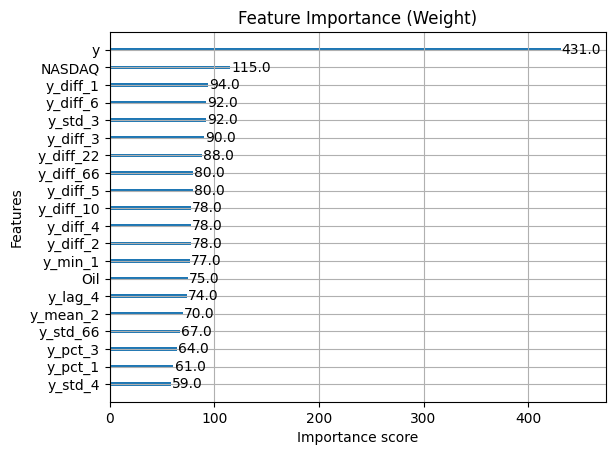

Weight Threshold: 21.55
Selected Weight Features: ['y', 'NASDAQ', 'y_diff_1', 'y_diff_6', 'y_std_3', 'y_diff_3', 'y_diff_22', 'y_diff_5', 'y_diff_66', 'y_diff_4']


In [21]:
import matplotlib.pyplot as plt
import xgboost # Import the xgboost module

# Plot feature importance based on "weight" (number of times a feature appears in a tree)
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Weight)")
plt.show()

# 1. Get feature importance by weight
importance_dict = xgb.get_booster().get_score(importance_type='weight')

# 2. Convert to DataFrame
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort high → low
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Compute threshold = 10% of top feature
top_score = df_importance['Score'].iloc[0]
threshold = top_score * 0.05   # 5%

# 5. Select only strong features
df_top = df_importance[df_importance['Score'] >= threshold]

# 6. Convert to list
top_weight_features_list = df_top['Feature'].tolist()[:10:]

print("Weight Threshold:", threshold)
print("Selected Weight Features:", top_weight_features_list)

<Figure size 1000x600 with 0 Axes>

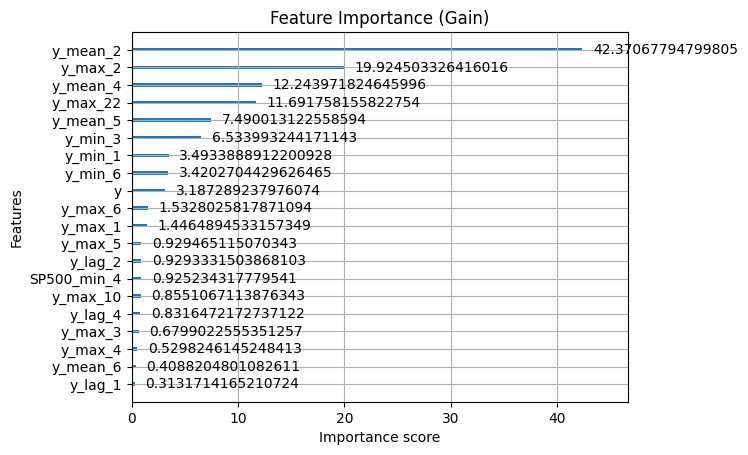

Threshold: 2.1185338973999026
Selected features: ['y_mean_2', 'y_max_2', 'y_mean_4', 'y_max_22', 'y_mean_5', 'y_min_3', 'y_min_1', 'y_min_6', 'y']


In [22]:
# OPTIONAL: Plot based on "gain" (average gain of splits which use the feature)
# "Gain" is often more accurate for finding what actually drives the prediction.
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, importance_type='gain', max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Gain)")
plt.show()

# 1. Build importance DataFrame
importance_dict = xgb.get_booster().get_score(importance_type='gain')
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 2. Sort high to low
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 3. Compute threshold = 10% of top feature
top_score = df_importance['Score'].iloc[0]
threshold = top_score * 0.05

# 4. Select features with Score >= threshold
df_top = df_importance[df_importance['Score'] >= threshold]

# 5. Extract feature names
top_gain_features_list = df_top['Feature'].tolist()[:10:]

print("Threshold:", threshold)
print("Selected features:", top_gain_features_list)

In [23]:
top_features = list(set(top_gain_features_list) | set(top_weight_features_list))
top_features

['y',
 'y_min_6',
 'y_mean_4',
 'y_max_2',
 'y_diff_4',
 'y_diff_6',
 'NASDAQ',
 'y_diff_22',
 'y_min_1',
 'y_mean_5',
 'y_diff_1',
 'y_std_3',
 'y_diff_66',
 'y_diff_5',
 'y_diff_3',
 'y_mean_2',
 'y_min_3',
 'y_max_22']

# Final df for this TKL

In [24]:
final_df = df[['Date','y_next'] + top_features]

for col in top_features + ['y_next']:
  final_df[f"{col}_orig"] = df_orig[col]

display(final_df.tail(1))
final_df.info()

,Date,y_next,y,y_min_6,y_mean_4,y_max_2,y_diff_4,y_diff_6,NASDAQ,y_diff_22,...,y_mean_5_orig,y_diff_1_orig,y_std_3_orig,y_diff_66_orig,y_diff_5_orig,y_diff_3_orig,y_mean_2_orig,y_min_3_orig,y_max_22_orig,y_next_orig
6999,2025-12-17,0.139285,0.141649,0.136364,0.143499,0.141649,-0.008457,-0.004228,0.962923,0.009514,...,0.162,0.0,0.000577,-0.001,0.005,-0.006,0.159,0.159,0.167,0.156764


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            7000 non-null   datetime64[ns]
 1   y_next          7000 non-null   float64       
 2   y               7000 non-null   float64       
 3   y_min_6         7000 non-null   float64       
 4   y_mean_4        7000 non-null   float64       
 5   y_max_2         7000 non-null   float64       
 6   y_diff_4        7000 non-null   float64       
 7   y_diff_6        7000 non-null   float64       
 8   NASDAQ          7000 non-null   float64       
 9   y_diff_22       7000 non-null   float64       
 10  y_min_1         7000 non-null   float64       
 11  y_mean_5        7000 non-null   float64       
 12  y_diff_1        7000 non-null   float64       
 13  y_std_3         7000 non-null   float64       
 14  y_diff_66       7000 non-null   float64       
 15  y_di

# CSV

In [25]:
if project_config["dataprep.override_csv"] == '1':

  df_csv_path = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
  final_df[:-2:].to_csv(df_csv_path)